In [65]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold

# Optional: XGBoost / LightGBM
try:
    from xgboost import XGBClassifier
    xgb_available = True
except ImportError:
    xgb_available = False

try:
    from lightgbm import LGBMClassifier
    lgbm_available = True
except ImportError:
    lgbm_available = False

### Select Features and Target

In [27]:
df = pd.read_pickle("../data/processed/fraud_df.pkl") # Read the pickle file

X = df.drop('fraud_reported', axis=1)
y = df['fraud_reported'].map({'Y': 1, 'N': 0})  # Convert target to binary

In [28]:
# Convert date and time features to numeric

X['year_policy_bind_year'] = X['policy_bind_date'].dt.year
X['month_policy_bind_year'] = X['policy_bind_date'].dt.month
X['day_policy_bind_year'] = X['policy_bind_date'].dt.day
# Dann entfernen:
X = X.drop(columns=['policy_bind_date'])

X['year_incident_date'] = X['incident_date'].dt.year
X['month_incident_date'] = X['incident_date'].dt.month
X['day_incident_date'] = X['incident_date'].dt.day
# Dann entfernen:
X = X.drop(columns=['incident_date'])

### Handle Categorical Features (One-Hot Encoding)

In [29]:
X = pd.get_dummies(X, drop_first=True)

### Train-Test Split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Model choice (Cross-Validation mit ROC-AUC)

In [64]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier()
}

if xgb_available:
    models["XGBoost"] = XGBClassifier(scale_pos_weight=(y == 0).sum() / (y == 1).sum(),
                                      use_label_encoder=False, eval_metric='logloss')
if lgbm_available:
    models["LightGBM"] = LGBMClassifier(class_weight='balanced')

In [66]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    results[name] = scores
    print(f"{name}: ROC-AUC mean={scores.mean():.3f}, std={scores.std():.3f}")


Logistic Regression: ROC-AUC mean=0.588, std=0.042
Decision Tree: ROC-AUC mean=0.750, std=0.026
Random Forest: ROC-AUC mean=0.821, std=0.031
Gradient Boosting: ROC-AUC mean=0.880, std=0.021
XGBoost: ROC-AUC mean=0.855, std=0.020
LightGBM: ROC-AUC mean=0.851, std=0.025


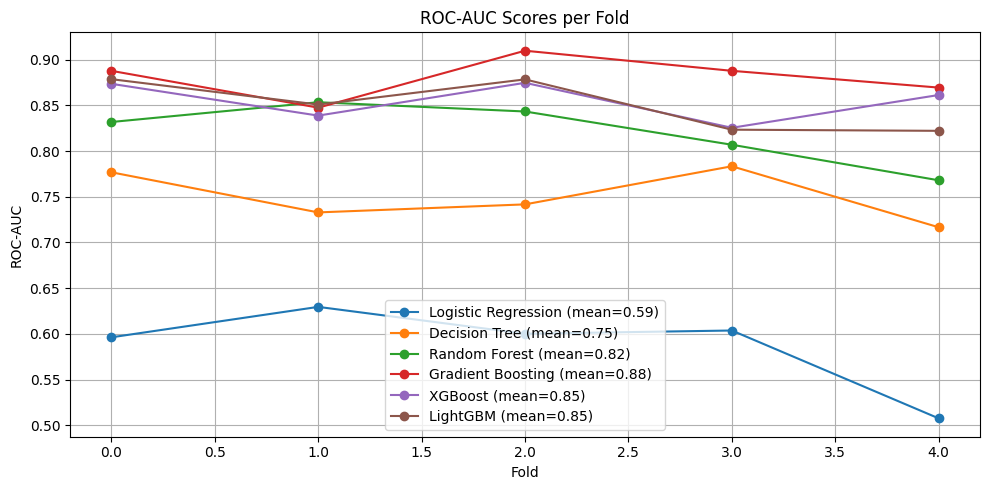

In [67]:
plt.figure(figsize=(10, 5))
for name, scores in results.items():
    plt.plot(scores, label=f"{name} (mean={np.mean(scores):.2f})", marker='o')
plt.title("ROC-AUC Scores per Fold")
plt.xlabel("Fold")
plt.ylabel("ROC-AUC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
### Train a Gradient Bossting model

### Train a Random Forest model

In [46]:
# Pipeline mit SMOTE + RandomForest

pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])


In [ ]:
#### Use GridSearch for hyperparameter optimization

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt']
}

grid_search = GridSearchCV(pipe,
                           param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(grid_search.best_params_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}


### Evaluate the model

In [51]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

[[143   8]
 [ 46   3]]
              precision    recall  f1-score   support

           0       0.76      0.95      0.84       151
           1       0.27      0.06      0.10        49

    accuracy                           0.73       200
   macro avg       0.51      0.50      0.47       200
weighted avg       0.64      0.73      0.66       200

ROC-AUC: 0.6800919043113934


### ROC Curve

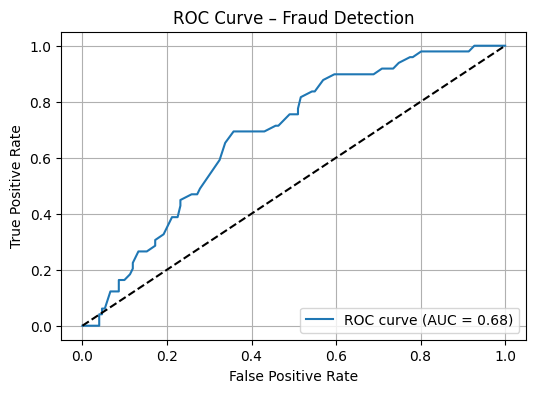

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonale Linie = Zufall
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Fraud Detection')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Precision Recall Curve 

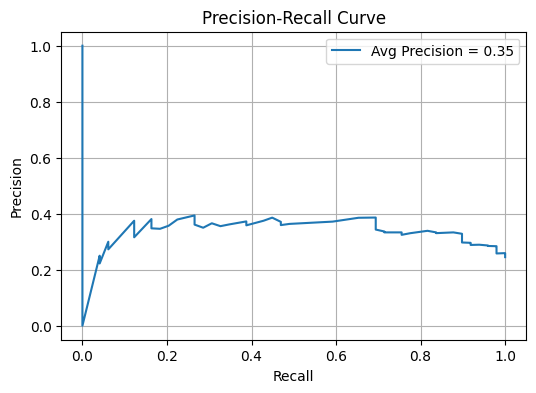

In [ ]:

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"Avg Precision = {ap:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


### Feature Importances

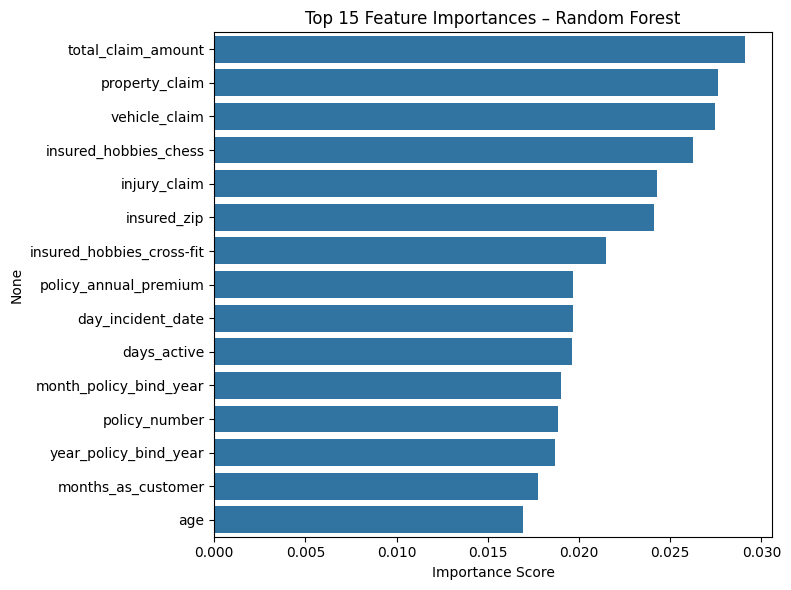

In [ ]:
rf = best_model.named_steps['clf']

importances = pd.Series(rf.feature_importances_, index=X.columns)
top_importances = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_importances, y=top_importances.index)
plt.title("Top 15 Feature Importances – Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()
